In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import pandas as pd

In [2]:
folder_list = sorted(os.walk("./result").__next__()[1])

lst_A = folder_list[1:5]
lst_B = folder_list[5:9]
lst_C = folder_list[9:13]

print(lst_A, lst_B, lst_C)

['144', '160', '176', '192'] ['208', '224', '240', '256'] ['272', '288', '304', '320']


In [3]:
def merge(lst):
    merged_gt = []
    merged_seg = []
    
    for folder in lst:
        gt_list = sorted(glob.glob('./result_Semirand/' + folder + '/GT*.jpg'))
        seg_list = sorted(glob.glob('./result_Semirand/' + folder + '/SEG*.jpg'))
        
        merged_gt += gt_list
        merged_seg += seg_list
    
    return merged_gt, merged_seg

In [4]:
merged_A_gt, merged_A_seg = merge(lst_A)
merged_B_gt, merged_B_seg = merge(lst_B)
merged_C_gt, merged_C_seg = merge(lst_C)

print(len(merged_C_gt))

24024


In [5]:
def DSC_list(gt_list, seg_list):
    
    DSC_list = []
    GT_sum = []
    
    for i in range(len(gt_list)):
        
        GT = cv2.imread(gt_list[i], 0) / 255

        GT[GT > 0.5] = 1
        GT[GT <= 0.5] = 0

        AUTO = cv2.imread(seg_list[i], 0) / 255

        AUTO[AUTO > 0.5] = 1
        AUTO[AUTO <= 0.5] = 0

        A_Intersect_G = np.multiply(AUTO, GT)
                
        DSC = (2 * np.sum(A_Intersect_G)) / (np.sum(AUTO) + np.sum(GT))

        DSC_list.append(DSC)
        GT_sum.append(np.sum(GT))
      
    return DSC_list


In [6]:
DSC_list_A = DSC_list(merged_A_gt, merged_A_seg)
DSC_list_B = DSC_list(merged_B_gt, merged_B_seg)
DSC_list_C = DSC_list(merged_C_gt, merged_C_seg)


## Group Comparison

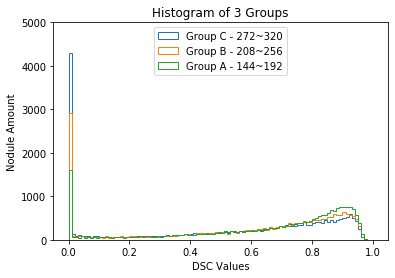

In [42]:
# x axis All
bins = np.arange(0,1+0.01,0.01)

plt.hist(DSC_list_C, bins, label='Group C - 272~320', histtype='step')
plt.hist(DSC_list_B, bins, label='Group B - 208~256', histtype='step')
plt.hist(DSC_list_A, bins, label='Group A - 144~192', histtype='step')

plt.xlabel('DSC Values')
plt.ylabel('Nodule Amount')
plt.title('Histogram of 3 Groups')
#plt.xlim(0.1,1)
plt.ylim(0,5000)
plt.legend(loc='upper center')
plt.savefig('DSC_Groups_0', dpi=300)

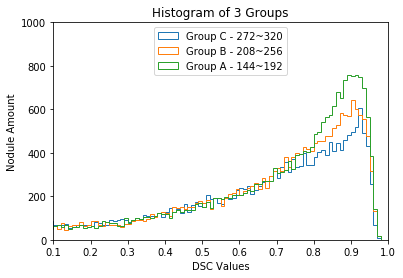

In [44]:
# x axis exclude 0
bins = np.arange(0,1+0.01,0.01)

plt.hist(DSC_list_C, bins, label='Group C - 272~320', histtype='step')
plt.hist(DSC_list_B, bins, label='Group B - 208~256', histtype='step')
plt.hist(DSC_list_A, bins, label='Group A - 144~192', histtype='step')

plt.xlabel('DSC Values')
plt.ylabel('Nodule Amount')
plt.title('Histogram of 3 Groups')
plt.xlim(0.1,1)
plt.ylim(0,1000)
plt.legend(loc='upper center')
plt.savefig('DSC_Groups_0_1', dpi=300)

## Original Image


In [10]:
gt_list = sorted(glob.glob('./result/512/GT*.jpg'))
seg_list = sorted(glob.glob('./result/512/SEG*.jpg'))
        

DSC_Original = DSC_list(gt_list, seg_list)


(0, 100)

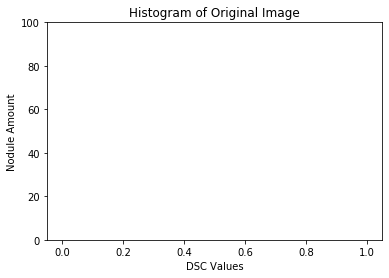

In [11]:
bins = np.arange(0,1+0.01,0.01)

plt.hist(DSC_Original, bins, histtype='step')
plt.xlabel('DSC Values')
plt.ylabel('Nodule Amount')
plt.title('Histogram of Original Image')
#plt.xlim(0.1,1)
plt.ylim(0,100)



## Comparison among Groups

In [20]:
def Group_Plot(DSC_list, group, sizes):
    
    bins = np.arange(0,1+0.02,0.02)
    i = 2004

    plt.hist(DSC_list[0:i], bins, label= sizes[0], histtype='step', )
    plt.hist(DSC_list[i:2*i], bins, label= sizes[1], histtype='step')
    plt.hist(DSC_list[2*i:3*i], bins, label= sizes[2], histtype='step')
    plt.hist(DSC_list[3*i:4*i], bins, label= sizes[3], histtype='step')
    #plt.hist(DSC_Original*3, bins, label='Original', histtype='step', alpha=0.5)

    plt.xlabel('DSC Values')
    plt.ylabel('Nodule Amount')
    plt.title('Histogram of DSC Group '+ group)
    #plt.xlim(0.1,1)
    plt.ylim(0,200)
    plt.legend(loc='upper center')
    plt.savefig('DSC_Group_'+group, dpi=300)
    
    

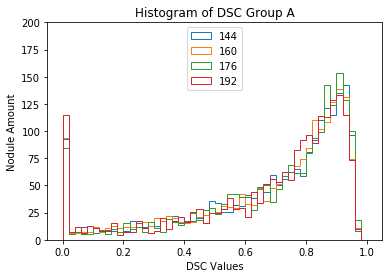

In [21]:
Group_Plot(DSC_list_A, 'A', lst_A )

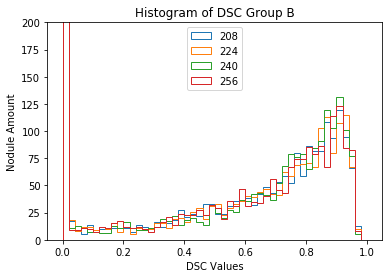

In [22]:
Group_Plot(DSC_list_B, 'B', lst_B )

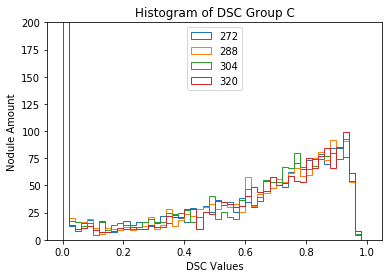

In [23]:
Group_Plot(DSC_list_C, 'C', lst_C )

In [24]:
## Number of High, Low DSCs 
def DSC_count(DSC_list):
    high = 0
    low = 0
    for item in DSC_list:
        if item > 0.95:
            high += 1
        if item < 0.05:
            low +=1
    
    mean = np.mean(DSC_list)
            
    return high, low, mean

In [25]:
def split(DSC_list, length):

    DSC_split = []
    j = 2004
    for i in range(length):
        
        DSC_split.append(DSC_list[j*i:j*(i+1)]) # Merge 된거 4개씩 나눠서 split에 넣음
    
    print(len(DSC_split))
    return DSC_split


In [26]:
def Individual_Plot(DSC_list, sizes, group, length):
    
    DSC_split = split(DSC_list, length)
    high_list = []
    low_list = []
    mean_list = []
    for i in range(len(DSC_split)):
        high, low, mean = DSC_count(DSC_split[i])
        high_list.append(high)
        low_list.append(low)
        mean_list.append(mean)
    
    df = pd.DataFrame({'Low': low_list, 'High': high_list}, index=sizes)
    ax = df.plot.bar(rot=0)
    
    plt.xlabel('Sizes')
    plt.ylabel('Nodule Amount')
    plt.title('Number of Low / High DSCs Group '+group)
    plt.savefig('DSC_Group_'+ group +' Bar', dpi=300)
    
    

4


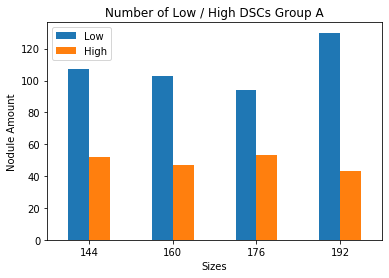

In [27]:
Individual_Plot(DSC_list_A, lst_A, 'A', 4)

4


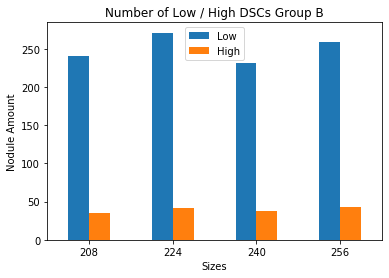

In [28]:
Individual_Plot(DSC_list_B, lst_B, 'B', 4)

4


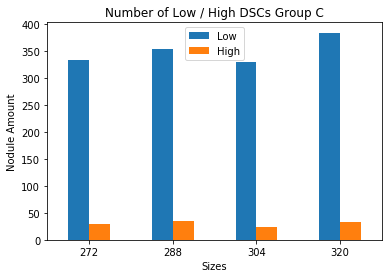

In [29]:
Individual_Plot(DSC_list_C, lst_C, 'C', 4)

In [30]:
DSC_merged = DSC_list_A + DSC_list_B + DSC_list_C
lst_merged = lst_A + lst_B + lst_C

12


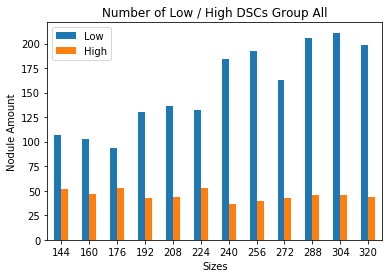

In [31]:
Individual_Plot(DSC_merged, lst_merged, 'All', 12 )

In [32]:
New_merged = DSC_list_A + DSC_list_B[:2004*2]
New_lst_merged = lst_A + lst_B[:2]
print(len(New_merged))

28032


6


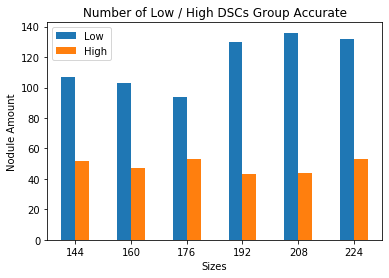

In [33]:
Individual_Plot(New_merged, New_lst_merged, 'Accurate', 6 )

## Original Image

In [ ]:
bins = np.arange(0,1+0.01,0.01)

plt.hist(DSC_Original*4*3, bins, label='Original x 4', histtype='step')
plt.hist(DSC_list_C, bins, label='Group C - 272~320', histtype='step')
plt.hist(DSC_list_B, bins, label='Group B - 208~256', histtype='step')
plt.hist(DSC_list_A, bins, label='Group A - 144~192', histtype='step')

plt.xlabel('DSC Values')
plt.ylabel('Nodule Amount')
plt.title('Histogram of 3 Groups')
#plt.xlim(0.1,1)
plt.ylim(0,8000)
plt.legend(loc='upper center')
plt.savefig('DSC_Groups', dpi=300)